In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**First we'll be importing all the necessary libraries**

In [2]:
#pip install tensorflow==2.5

In [3]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Reading the datasets from the directory**

In [4]:
data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
data.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


**Information Extraction from keywords given to the patients after diagnosed**

In [5]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

Attaching labels based whether cataract is present on which eye (left/right)

In [6]:


#data[data.O==1].head(20)  #drusen or epiretinal membrane

def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    
    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    
    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    
    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    
    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    
    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values
    
    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values
    
    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values 

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values 
    
    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values 
    
    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);
    
    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [7]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal Images::" , len(normal))
print("Cataract Images::" , len(cataract))
print("Diabetes Images::" , len(diab))
print("Glaucoma Images::" , len(glaucoma))
print("Hypertension Images::" , len(hyper))
print("Myopia Images::" , len(myopia))
print("Age Issues Images::" , len(age))
print("Other Images::" , len(other))


Dataset stats::
Normal Images:: 700
Cataract Images:: 594
Diabetes Images:: 1818
Glaucoma Images:: 610
Hypertension Images:: 374
Myopia Images:: 479
Age Issues Images:: 551
Other Images:: 324


Now since we have segregated the images to N and C labels <br>
We need to create a Dataset for VGG19 where it will do the image extraction and then assign the label<br>

In [8]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
image_size=224
labels = []
dataset = []
def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        #image category here would be either normal or cataract
        imgpath = os.path.join(dataset_dir,img);
        
        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);
    
    return dataset;

Generating Dataset

In [9]:
# Normal == 0
# Cataract == 1
# Diabetes == 2
# Glaucoma == 3
# HyperTension == 4
# Myopia == 5
# Age == 6
# Other == 7

dataset = dataset_generator(normal,0)
dataset = dataset_generator(cataract,1)
dataset = dataset_generator(diab,2)
dataset = dataset_generator(glaucoma,3)
dataset = dataset_generator(hyper,4)
dataset = dataset_generator(myopia,5)
dataset = dataset_generator(age,6)
dataset = dataset_generator(other,7)

len(dataset)


100%|██████████| 324/324 [00:02<00:00, 116.18it/s]


5396

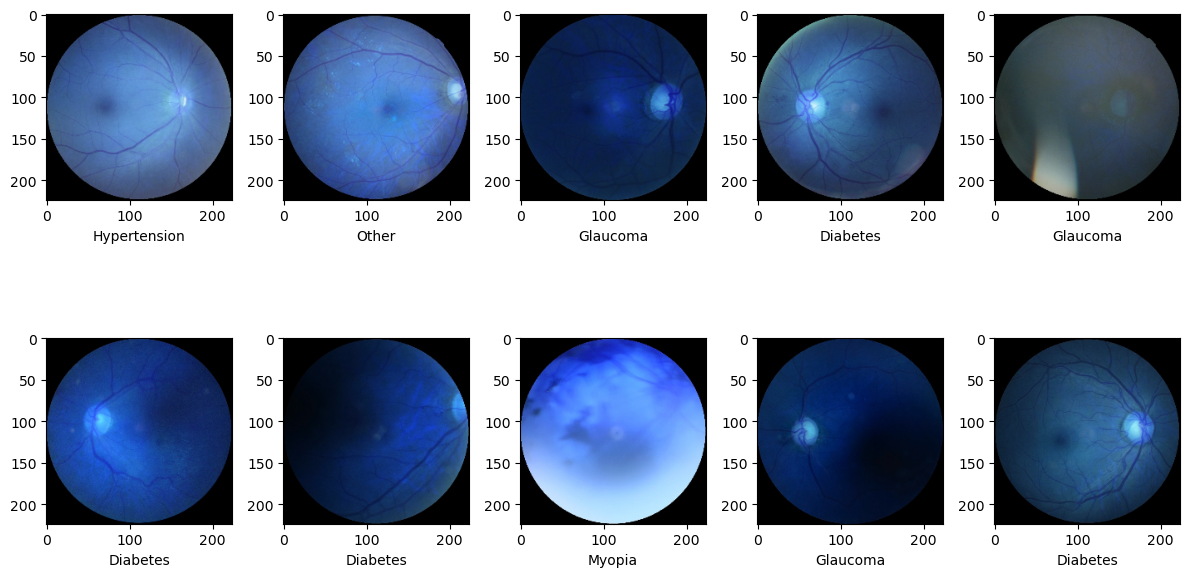

In [10]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
           
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [11]:
#Divide the dataset into 2 predictors and target...
#here predictors would be the image and target would be the label

train_x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3);
train_y = np.array([i[1] for i in dataset])

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
#splitting the dataset
x_train , x_test , y_train, y_test = train_test_split(train_x,train_y, test_size=0.2)

y_train_cat = to_categorical(y_train,num_classes=8)

y_test_cat = to_categorical(y_test,num_classes = 8)


Creating the Model

In [12]:
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(256,activation = "relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(8,activation="softmax"))

model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              10

In [13]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#u might have to apply train_generator and test_generator
history = model.fit(x_train,y_train_cat,batch_size=32,epochs=15)
print(history)

Epoch 1/15
135/135 [==============================] - 23s 95ms/step - loss: 1.3728 - accuracy: 0.5368
Epoch 2/15
135/135 [==============================] - 10s 74ms/step - loss: 0.7164 - accuracy: 0.7614
Epoch 3/15
135/135 [==============================] - 10s 75ms/step - loss: 0.4947 - accuracy: 0.8429
Epoch 4/15
135/135 [==============================] - 10s 75ms/step - loss: 0.3591 - accuracy: 0.8913
Epoch 5/15
135/135 [==============================] - 10s 75ms/step - loss: 0.2594 - accuracy: 0.9252
Epoch 6/15
135/135 [==============================] - 10s 75ms/step - loss: 0.2375 - accuracy: 0.9316
Epoch 7/15
135/135 [==============================] - 10s 75ms/step - loss: 0.2143 - accuracy: 0.9310
Epoch 8/15
135/135 [==============================] - 10s 75ms/step - loss: 0.1891 - accuracy: 0.9458
Epoch 9/15
135/135 [==============================] - 10s 75ms/step - loss: 0.1638 - accuracy: 0.9504
Epoch 10/15
135/135 [==============================] - 10s 75ms/step - loss: 0.183

In [14]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

34/34 [==============================] - 5s 143ms/step - loss: 1.0708 - accuracy: 0.7907
Accuracy: 0.7907407283782959


## Predictions

In [15]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = np.array((model.predict(x_test) > 0.5).astype("int32"))

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

34/34 [==============================] - 3s 69ms/step
[3, 6, 2, 0, 2, 2, 2, 5, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 1, 6, 2, 1, 0, 2, 5, 5, 2, 5, 4, 0, 5, 2, 3, 4, 6, 2, 2, 0, 5, 3, 2, 6, 7, 1, 2, 1, 2, 3, 3, 4, 7, 1, 2, 6, 2, 5, 2, 5, 3, 2, 3, 3, 6, 5, 5, 2, 5, 2, 5, 2, 6, 7, 2, 2, 1, 5, 6, 3, 1, 2, 2, 1, 1, 6, 1, 5, 4, 1, 2, 2, 1, 2, 2, 6, 0, 6, 3, 0, 5, 6, 0, 6, 0, 2, 2, 1, 2, 6, 3, 3, 2, 1, 2, 4, 1, 3, 6, 1, 2, 2, 2, 2, 2, 5, 2, 0, 6, 6, 3, 2, 6, 5, 1, 2, 5, 4, 2, 5, 2, 2, 2, 4, 5, 6, 2, 2, 3, 5, 0, 4, 3, 5, 3, 2, 1, 2, 4, 2, 2, 7, 6, 4, 4, 5, 1, 4, 2, 2, 2, 2, 4, 2, 6, 5, 1, 2, 6, 7, 7, 3, 5, 2, 2, 2, 2, 0, 5, 5, 2, 6, 7, 5, 2, 3, 6, 0, 2, 0, 3, 2, 5, 5, 3, 2, 6, 7, 1, 3, 2, 3, 4, 6, 3, 6, 2, 2, 6, 3, 1, 3, 2, 5, 1, 7, 6, 2, 2, 3, 6, 2, 2, 3, 1, 2, 6, 5, 6, 2, 2, 7, 1, 0, 1, 2, 2, 3, 0, 6, 5, 6, 1, 4, 6, 3, 4, 0, 2, 7, 2, 2, 3, 0, 6, 0, 1, 4, 1, 2, 2, 4, 2, 3, 3, 3, 6, 2, 3, 6, 2, 2, 2, 2, 2, 4, 3, 3, 2, 6, 2, 1, 4, 1, 0, 3, 2, 3, 1, 5, 2, 3, 6, 2, 1, 2, 2, 6, 2, 3, 0, 4, 2, 7, 1, 7, 1, 

In [16]:
print(accuracy_score(y_test,y_pred))

0.7907407407407407


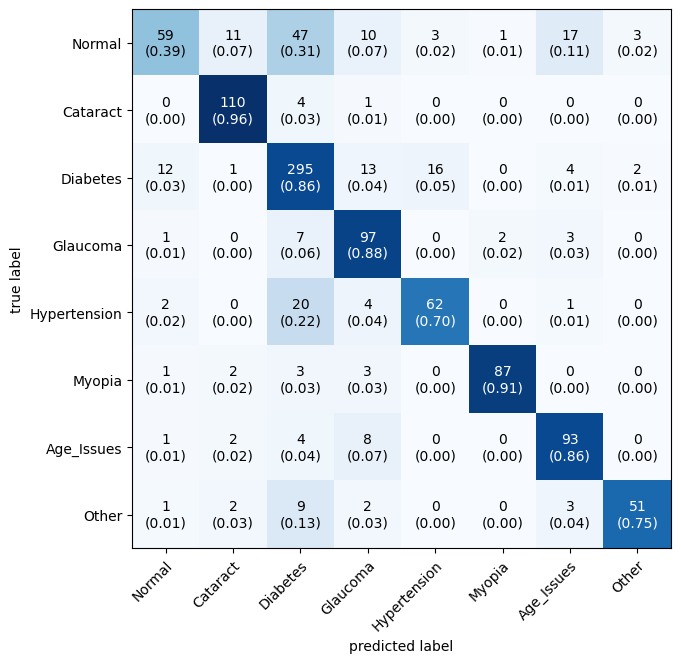

In [17]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract","Diabetes","Glaucoma","Hypertension","Myopia","Age_Issues","Other"],show_normed = True);

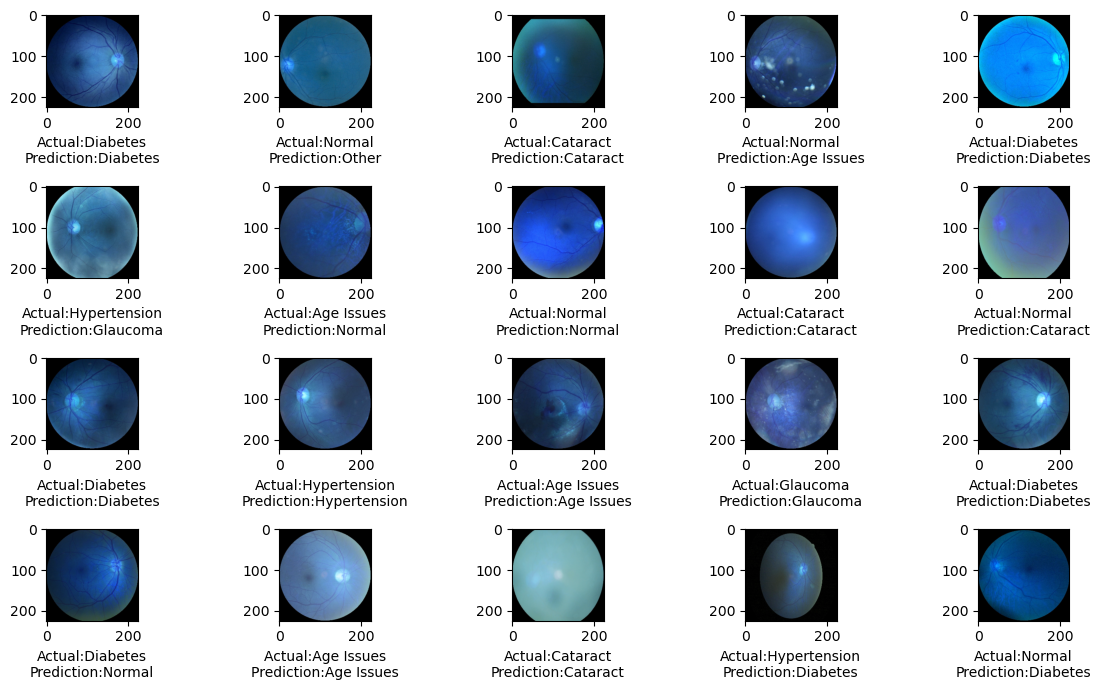

In [18]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 


## Accuracy using K-Fold Splitting

In [19]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# evaluate the model
scores = []
for train_index, test_index in kfold.split(train_x):
    # get the training and testing data for this fold
    X_train, X_test = train_x[train_index], train_x[test_index]
    ytrain = to_categorical(train_y[train_index],num_classes=8)
    ytest = to_categorical(train_y[test_index],num_classes=8)

    # train the model
    model.fit(X_train, ytrain, epochs=5, batch_size=32, verbose=0)

    # evaluate the model
    score = model.evaluate(X_test, ytest, verbose=0)
    scores.append(score[1])

# calculate the average performance
mean_score = np.mean(scores)
std_score = np.std(scores)
print("Accuracy: %.2f%% (+/- %.2f%%)" % (mean_score*100, std_score*100))

Accuracy: 92.07% (+/- 1.07%)
